# Risk Analytics

In the previous section we demontated some Python capabilities to analyse and visualise AWS S3 data using Python packages. In this section, we will demonstrate from Risk analytics functionalities using the S3 data, particularly **Value-at-Risk (VaR)**, computed using using historical method and monte-carlo simualtion

## Load equity data from S3 bucket

In [1]:
import boto3
import smart_open as so
import pandas as pd
bucket = 'rsdg-s3-bucket-fin-demo'

def get_s3_keys(pS3Client, pBucket):
    """Get a list of keys in an S3 bucket."""
    _keys = {}
    resp = pS3Client.list_objects_v2(Bucket=pBucket)
    for obj in resp['Contents']:
        _key = obj['Key']
        _size = obj['Size']
        _keys[_key] = _size
    return _keys

def build_df_from_s3(pBucket, pSession):
    _combined_equity_df = pd.DataFrame()
    for key in keysAndSizes:
        file = bucket + '/' +key
        single_equity_df = pd.DataFrame()
        single_equity_df = pd.read_csv(so.open('s3://' +  file, transport_params=dict(session= pSession) ))
        single_equity_df['Stock'] = key.replace('.txt','')
        _combined_equity_df = _combined_equity_df.append(single_equity_df, ignore_index=True)
    return _combined_equity_df


_session = boto3.Session(profile_name='fin-demo')
s3 = _session.client('s3')
keysAndSizes = get_s3_keys(s3, bucket)
combined_equity_df = build_df_from_s3(bucket,_session)

In [2]:
import numpy
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas
from datetime import datetime
mpl.rcParams['figure.figsize'] = (9, 4) # use bigger graphs
%config InlineBackend.figure_formats=["png"]


## Value at Risk

### Historical Method

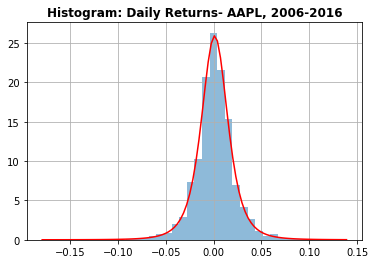

In [3]:
start_date = '2006-01-01'
end_date = '2016-12-31'
df_2006_2016 = combined_equity_df[(combined_equity_df.Date >= start_date)&
                   (combined_equity_df.Date <= end_date) &
                   (combined_equity_df.Stock == "aapl.us")]

df_returns = df_2006_2016["Close"].pct_change().dropna()
df_mean = df_returns.mean()
df_sigma = df_mean.std()
dist = numpy.linspace(df_returns.min(), df_returns.max(), 100)
tdf, tmean, tsigma = scipy.stats.t.fit(df_returns)
df_returns.hist(bins=40, density=True, histtype="stepfilled", alpha=0.5)
plt.plot(dist, scipy.stats.t.pdf(dist, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.title("Histogram: Daily Returns- AAPL, 2006-2016", weight="bold");

In [4]:
print(df_returns.quantile(0.05))
print(df_returns.quantile(0.01))

-0.031049800888801216
-0.05671712199662707


In [5]:
num_days = 300   # time horizon
inv_num_days = 1/float(num_days)
sigma = 0.04 # volatility
mu = 0.05  # drift (average growth rate)

## Monte Carlo Simulation

### Simulating Normal Walk

Text(0, 0.5, 'Price')

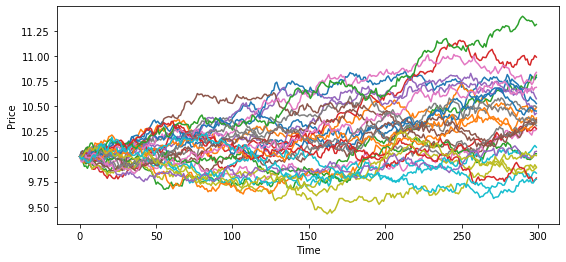

In [6]:
def generate_normal_walk(p_start_price):
    price = numpy.zeros(num_days)
    delta_return = numpy.zeros(num_days)
    price[0] = p_start_price
    for ii in range(1, num_days):
        delta_return[ii] = numpy.random.normal(loc=mu * inv_num_days, scale=sigma * numpy.sqrt(inv_num_days))
        price[ii] = max(0, price[ii-1] + delta_return[ii] * price[ii-1])
    return price

plt.figure(figsize=(9,4))    
for run_index in range(30):
    plt.plot(generate_normal_walk(10.0))
plt.xlabel("Time")
plt.ylabel("Price")


### Building Monte-Carlo based VaR

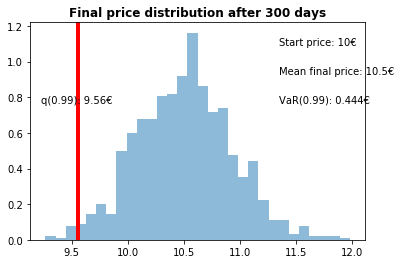

In [7]:
num_runs = 1000
simulations = numpy.zeros(num_runs)

for run_num in range(num_runs):
    simulations[run_num] = generate_normal_walk(10.0)[num_days-1]
q = numpy.percentile(simulations, 1)

plt.hist(simulations, density=True, bins=30, histtype="stepfilled", alpha=0.5)
plt.figtext(0.7, 0.8, "Start price: 10€")
plt.figtext(0.7, 0.7, "Mean final price: {:.3}€".format(simulations.mean()))
plt.figtext(0.7, 0.6, "VaR(0.99): {:.3}€".format(10 - q))
plt.figtext(0.15, 0.6, "q(0.99): {:.3}€".format(q))
plt.axvline(x=q, linewidth=4, color="r")
plt.title("Final price distribution after {} days".format(num_days), weight="bold");

### Related notebooks
* [00-Setup](./00_setup.ipynb) 
* [01-Process S3 using python](./01_Process_s3_files.ipynb)
* [02-Visualization and Analytics](./02_Visualization_and_Analytics.ipynb)
* [03-Risk Analytics](./03_Risk_Analytics.ipynb)
* [04-Exploring Firehose,Athena and Quicksight](./04_Exploring_Kinesis_Firehose.ipynb)
* [05-Athena and Quicksights](./05_Athena_Quicksight.ipynb)
* [06-Sagemaker to run the notebooks](./06_Sagemaker_jupyterlab.ipynb)
* [07_Transform stream data using Lambda](./07_Transform_lambda.ipynb)
* [08_Move data to Redshift using Glue](./08_Glue_Redshift.ipynb)
* [09_CI/CD Terrform with Travis CI](./09_Integrating_terraform_travisci.ipynb)